In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
image_path = "C:/Users/sneha/OneDrive/Desktop/college/ML/Image_captioning/Images"

In [4]:
import pandas as pd
data = pd.read_csv("C:/Users/sneha/OneDrive/Desktop/college/ML/Image_captioning/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [30]:
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array
from textwrap import wrap
import matplotlib.pyplot as plt

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

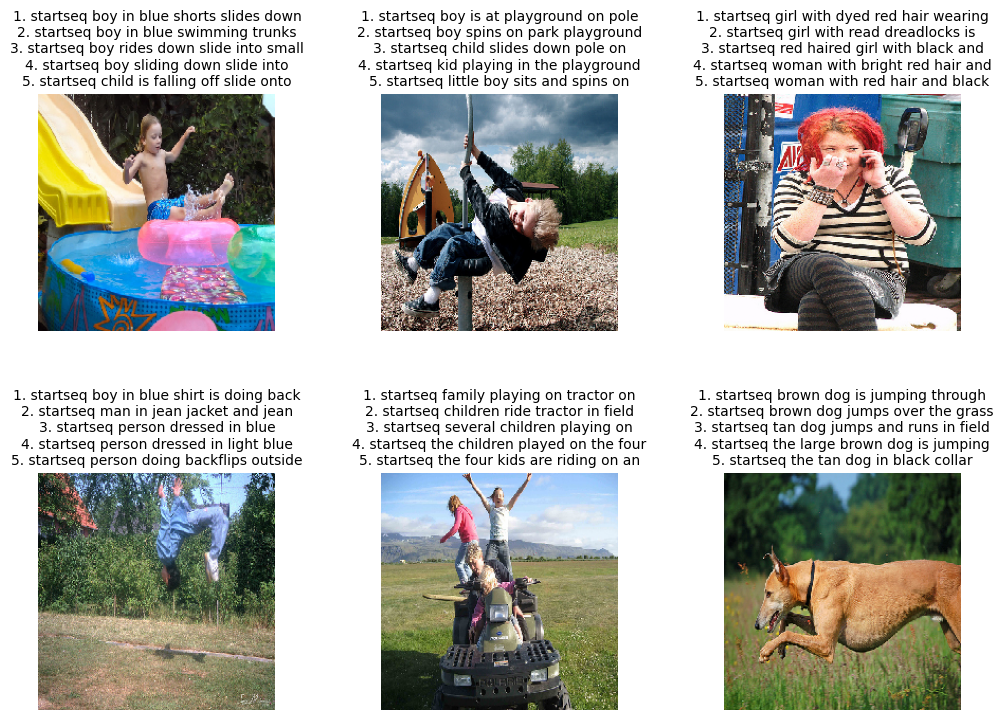

In [31]:
def display_images_with_captions(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(12, 8))
    n = 0
    for i in range(min(6, len(temp_df))):
        n += 1
        plt.subplot(2,3, n)
        plt.subplots_adjust(hspace= 0.6, wspace=0.4)

        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.axis("off")

        image_data = data[data['image'] == temp_df.image[i]]
        captions = image_data['caption'].tolist()
        caption_text = "\n".join([f"{j+1}. {wrap(c, 40)[0]}" for j, c in enumerate(captions[:5])])
        plt.title(caption_text, fontsize=10)

display_images_with_captions(data.sample(6))

In [32]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq startseq child in pink dress is climbing up set of stairs in an entry way endseq endseq',
 'startseq startseq girl going into wooden building endseq endseq',
 'startseq startseq little girl climbing into wooden playhouse endseq endseq',
 'startseq startseq little girl climbing the stairs to her playhouse endseq endseq',
 'startseq startseq little girl in pink dress going into wooden cabin endseq endseq',
 'startseq startseq black dog and spotted dog are fighting endseq endseq',
 'startseq startseq black dog and tri-colored dog playing with each other on the road endseq endseq',
 'startseq startseq black dog and white dog with brown spots are staring at each other in the street endseq endseq',
 'startseq startseq two dogs of different breeds looking at each other on the road endseq endseq',
 'startseq startseq two dogs on pavement moving toward each other endseq endseq']

In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.90*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [34]:
import pickle 
import os
import numpy as np
from tensorflow.keras.applications import  DenseNet201
from tensorflow.keras.models import Model
from tqdm import tqdm

file_path = "features.pkl"
if os.path.exists(file_path):
    with open(file_path, "rb") as file:
        features = pickle.load(file)
    print("Features loaded from file.")
else:
    model = DenseNet201()
    fe = Model(inputs=model.input, outputs=model.layers[-2].output)

    img_size = 224
    features = {}
    for image in tqdm(data['image'].unique().tolist()):
       img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
       img = img_to_array(img)
       img = img/255.
       img = np.expand_dims(img,axis=0)
       feature = fe.predict(img, verbose=0)
       features[image] = feature

    with open(file_path, "wb") as file:
        pickle.dump(features, file)
    print("Saved 'features' to file.")

Features loaded from file.


In [35]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [36]:
from tensorflow.keras.layers import Input, Dense, concatenate, add
from tensorflow.keras.layers import Reshape, LSTM, Embedding, Dropout

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

caption_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    491,776 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 256)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 36, 256)   │  1,739,264 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 37, 256)   │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 256)       │    525,312 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 6794)      │    876,426 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,665,674 (13.98 MB)

 Trainable params: 3,665,674 (13.98 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss",mode="min",save_best_only = True,verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',  patience=3, verbose=1, factor=0.2, min_lr=0.00001)

In [39]:
from tensorflow.keras.models import load_model
import os

model_name = "model.keras"

if os.path.exists(model_name):
    print(f"Loading model from {model_name}...")
    caption_model = load_model(model_name)
    history = caption_model
else:
    print("Training the model...")
    history = caption_model.fit(
        train_generator,
        epochs=15,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction]
    )
    caption_model.save(model_name)
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


Loading model from model.keras...


generating the caption here

Feature shape: (1, 1920)
Sequence shape: (1, 34)
Sequence shape: (1, 34)
Sequence shape: (1, 34)
Sequence shape: (1, 34)
Sequence shape: (1, 34)
Sequence shape: (1, 34)
Sequence shape: (1, 34)


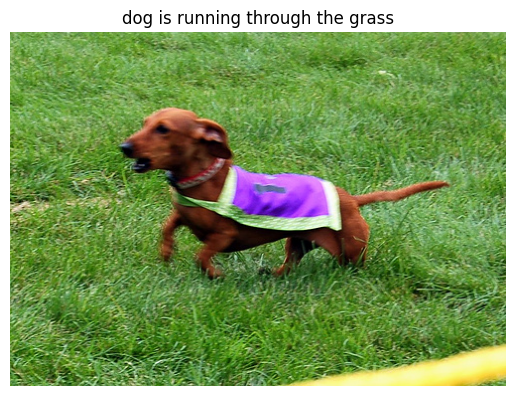

Image: 241046599_28b0ca7b9f.jpg
Caption: dog is running through the grass


In [61]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
import pickle
import random
import os

# Load data
data = pd.read_csv("C:/Users/sneha/OneDrive/Desktop/college/Image_captioning/captions.txt")
image_path = "C:/Users/sneha/OneDrive/Desktop/college/Image_captioning/Images"

# Load tokenizer, max_length, features, and model
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

max_length = 34  # Corrected to match the model's expected sequence length (None, 34)

with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

model_name = "model.keras"
caption_model = load_model(model_name)

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    # Ensure feature is 2D with shape (1, 1920)
    if feature.ndim == 1:  # Shape (1920,)
        feature = np.expand_dims(feature, axis=0)  # Shape (1, 1920)
    elif feature.ndim == 3:  # Shape (1, 1, 1920)
        feature = feature.reshape(-1, 1920)  # Shape (1, 1920)
    elif feature.ndim == 2 and feature.shape[0] != 1:  # Shape (n, 1920)
        feature = feature[:1]  # Shape (1, 1920)

    # Debugging: Print feature shape
    print(f"Feature shape: {feature.shape}")

    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Debugging: Print sequence shape
        print(f"Sequence shape: {sequence.shape}")
        y_pred = model.predict([feature, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

# Select a random image from the data['image'] column
sample_image = random.choice(data['image'].tolist())
image_file = os.path.join(image_path, sample_image)

# Verify the image file exists
if not os.path.exists(image_file):
    print(f"Image file {image_file} does not exist. Please check the image_path and data['image'] column.")
else:
    # Generate caption
    caption = predict_caption(caption_model, sample_image, tokenizer, max_length, features)
    caption = caption.replace("startseq ", "").replace(" endseq", "")

    # Display the image and the generated caption
    img = load_img(image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

    print(f"Image: {sample_image}")
    print(f"Caption: {caption}")

In [65]:
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

unique_images = data['image'].unique()
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
test_data = data[data['image'].isin(test_images)]

# Evaluation function
def evaluate_model(model, test_data, tokenizer, max_length, features):
    bleu_scores = []
    smoothing = SmoothingFunction().method1  # Smoothing for BLEU score

    for image in test_data['image'].unique():
        if image not in features:
            print(f"Skipping {image}: Features not found in features.pkl")
            continue

        # Generate caption
        feature = features[image]
        if feature.ndim == 1:
            feature = np.expand_dims(feature, axis=0)
        elif feature.ndim == 3:
            feature = feature.reshape(-1, 1920)
        elif feature.ndim == 2 and feature.shape[0] != 1:
            feature = feature[:1]

        in_text = "startseq"
        for i in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            y_pred = model.predict([feature, sequence], verbose=0)
            y_pred = np.argmax(y_pred)
            word = idx_to_word(y_pred, tokenizer)
            if word is None:
                break
            in_text += " " + word
            if word == 'endseq':
                break

        generated_caption = in_text.replace("startseq ", "").replace(" endseq", "")
        generated_words = generated_caption.split()

        # Get ground-truth captions
        ground_truth_captions = test_data[test_data['image'] == image]['caption'].tolist()
        ground_truth_words = [caption.split() for caption in ground_truth_captions]

        # Compute BLEU score
        bleu_score = sentence_bleu(ground_truth_words, generated_words, smoothing_function=smoothing)
        bleu_scores.append(bleu_score)

        print(f"Image: {image}, BLEU: {bleu_score:.4f}, Generated: {generated_caption}")

    # Calculate and report average BLEU score
    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0
    print(f"\nAverage BLEU Score on Test Set: {avg_bleu:.4f}")
    return avg_bleu

# Run evaluation
avg_bleu = evaluate_model(caption_model, test_data, tokenizer, max_length, features)
print(f"Model Accuracy (Average BLEU Score): {avg_bleu:.4f}")

Image: 1015118661_980735411b.jpg, BLEU: 0.3021, Generated: young girl in red shirt is standing on the sidewalk
Image: 1016887272_03199f49c4.jpg, BLEU: 0.1443, Generated: man in red shirt is climbing rock wall
Image: 1022454428_b6b660a67b.jpg, BLEU: 0.0228, Generated: two people are standing in front of the camera
Image: 102351840_323e3de834.jpg, BLEU: 0.1858, Generated: two people are standing in the snow
Image: 1028205764_7e8df9a2ea.jpg, BLEU: 0.0537, Generated: man is riding on the water
Image: 103195344_5d2dc613a3.jpg, BLEU: 0.0385, Generated: man is standing on the street
Image: 1032460886_4a598ed535.jpg, BLEU: 0.5348, Generated: man in white shirt is standing in front of the street
Image: 104136873_5b5d41be75.jpg, BLEU: 0.0454, Generated: man in black jacket is standing on the beach
Image: 1042590306_95dea0916c.jpg, BLEU: 0.1207, Generated: man in black shirt is standing in front of the camera
Image: 1056359656_662cee0814.jpg, BLEU: 0.0327, Generated: young girl in white shirt is 